In [2]:
# STEP 0 — install libs (run once)
!pip -q install kaggle transformers datasets accelerate peft sentencepiece bitsandbytes rouge-score bert-score sacrebleu sentence-transformers

# Upload kaggle.json via file dialog (Colab)
from google.colab import files
print("Please upload your kaggle.json file (from Kaggle Account -> API).")
uploaded = files.upload()  # choose kaggle.json

Please upload your kaggle.json file (from Kaggle Account -> API).


Saving kaggle.json to kaggle.json


In [3]:
# STEP 0.1 — place kaggle.json
import os, shutil, stat
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", stat.S_IRUSR | stat.S_IWUSR)
print("kaggle.json installed.")

kaggle.json installed.


In [10]:
# STEP 1.1 — REPLACE these with the exact Kaggle slugs you will use
ILDC_SUM_SLUG = "rishipjain/indian-court-judgment-summary-pair"
CIVIL_SUM_SLUG = "veerchheda/civilsum-indian-legal-document-summarisation"

DATA_DIR = "/content/data"
import os
os.makedirs(DATA_DIR, exist_ok=True)

print("Set ILDC_SUM_SLUG =", ILDC_SUM_SLUG)
print("Set CIVIL_SUM_SLUG =", CIVIL_SUM_SLUG)

Set ILDC_SUM_SLUG = rishipjain/indian-court-judgment-summary-pair
Set CIVIL_SUM_SLUG = veerchheda/civilsum-indian-legal-document-summarisation


In [12]:
# STEP 2 — Download datasets
!pip install -q kaggle

# Indian Court Judgment Summary dataset
ICJ_SUM_SLUG = "rishipjain/indian-court-judgment-summary-pair"

# CivilSum dataset
CIVIL_SUM_SLUG = "veerchheda/civilsum-indian-legal-document-summarisation"

DATA_DIR = "/content/data"
import os
os.makedirs(DATA_DIR, exist_ok=True)

# Download datasets
print("Downloading ICJ dataset...")
!kaggle datasets download -d {ICJ_SUM_SLUG} -p {DATA_DIR}

print("\nDownloading CivilSum dataset...")
!kaggle datasets download -d {CIVIL_SUM_SLUG} -p {DATA_DIR}

# Unzip all downloaded files to their specific directories
print("\nUnzipping datasets...")
!unzip -o "/content/data/indian-court-judgment-summary-pair.zip" -d "/content/data/icj_sum"
!unzip -o "/content/data/civilsum-indian-legal-document-summarisation.zip" -d "/content/data/civil_sum"

Dataset URL: https://www.kaggle.com/datasets/rishipjain/indian-court-judgment-summary-pair
License(s): MIT
indian-court-judgment-summary-pair.zip: Skipping, found more recently modified local copy (use --force to force download)

Dataset URL: https://www.kaggle.com/datasets/veerchheda/civilsum-indian-legal-document-summarisation
License(s): CC-BY-NC-SA-4.0
civilsum-indian-legal-document-summarisation.zip: Skipping, found more recently modified local copy (use --force to force download)

Unzipping datasets...
Archive:  /content/data/indian-court-judgment-summary-pair.zip
  inflating: /content/data/icj_sum/pair_dataset.csv  
Archive:  /content/data/civilsum-indian-legal-document-summarisation.zip
  inflating: /content/data/civil_sum/test.csv  
  inflating: /content/data/civil_sum/train.csv  
  inflating: /content/data/civil_sum/valid.csv  


In [15]:
# UPDATE THIS CODE ONLY VERSION
import pandas as pd
from datasets import Dataset
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from sklearn.model_selection import train_test_split
import os
import torch
!pip install -q evaluate
from evaluate import load

# -------------------------
# Step 1: Download and Unzip Datasets
# -------------------------
print("Setting up environment and downloading datasets...")
!pip install -q kaggle
!pip install -q evaluate
!pip install -q bert-score
DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(os.path.join(DATA_DIR, 'icj_sum'), exist_ok=True)
os.makedirs(os.path.join(DATA_DIR, 'civil_sum'), exist_ok=True)

# Define the correct Kaggle slugs
ICJ_SUM_SLUG = "rishipjain/indian-court-judgment-summary-pair"
CIVIL_SUM_SLUG = "veerchheda/civilsum-indian-legal-document-summarisation"

# Download both datasets
print("\nDownloading ICJ dataset...")
!kaggle datasets download -d {ICJ_SUM_SLUG} -p {DATA_DIR}
print("\nDownloading CivilSum dataset...")
!kaggle datasets download -d {CIVIL_SUM_SLUG} -p {DATA_DIR}

# Unzip to specific directories with correct file names
print("\nUnzipping datasets...")
!unzip -o "/content/data/indian-court-judgment-summary-pair.zip" -d "/content/data/icj_sum"
!unzip -o "/content/data/civilsum-indian-legal-document-summarisation.zip" -d "/content/data/civil_sum"

# -------------------------
# Step 2: Load and Prepare Data
# -------------------------
print("\nLoading and preparing datasets...")
icj_df = pd.read_csv("/content/data/icj_sum/pair_dataset.csv")
civil_sum_df = pd.read_csv("/content/data/civil_sum/train.csv")

# Fix ICJ dataset and add a 'domain' column
if "forum" not in icj_df.columns:
    icj_df["forum"] = "SC"
if "case_type" not in icj_df.columns:
    def extract_case_type(text):
        text = str(text).lower()
        if "appeal" in text: return "Appeal"
        elif "application" in text: return "Application"
        elif "petition" in text: return "Petition"
        elif "writ" in text: return "Writ"
        elif "civil" in text: return "Civil"
        elif "criminal" in text: return "Criminal"
        else: return "General"
    icj_df["case_type"] = icj_df["Judgment"].apply(extract_case_type)
icj_df["domain"] = "icj"

# Fix CivilSum dataset and add 'forum' and 'domain' columns
civil_sum_df["forum"] = "CC"
civil_sum_df["case_type"] = "Civil"
civil_sum_df["domain"] = "civilsum"

# Rename columns for consistency
icj_df = icj_df.rename(columns={'Judgment': 'document', 'Summary': 'summary'})
civil_sum_df = civil_sum_df.rename(columns={'text': 'document', 'summary': 'summary'})

# Combine the datasets
combined_df = pd.concat([icj_df[['document', 'summary', 'forum', 'case_type', 'domain']],
                         civil_sum_df[['document', 'summary', 'forum', 'case_type', 'domain']]], ignore_index=True)

# Handle missing values
combined_df['summary'] = combined_df['summary'].fillna('')
combined_df['document'] = combined_df['document'].fillna('')

# Create input text with control codes
combined_df["input_text"] = combined_df.apply(lambda r: f"<{r['domain']}> <{r['forum']}> <{r['case_type']}> {r['document']}", axis=1)

# Split the combined dataset into train, valid, and test
train_df, temp_df = train_test_split(combined_df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df.rename(columns={"summary": "summary"})[["input_text", "summary"]])
valid_dataset = Dataset.from_pandas(valid_df.rename(columns={"summary": "summary"})[["input_text", "summary"]])
test_dataset = Dataset.from_pandas(test_df.rename(columns={"summary": "summary"})[["input_text", "summary"]])

# -------------------------
# Step 3: Tokenizer, Model, and Preprocessing
# -------------------------
print("\nInitializing tokenizer and model...")
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)

special_tokens = {
    "additional_special_tokens": [
        "<icj>", "<civilsum>", "<SC>", "<CC>", "<HC>", "<DC>", "<Civil>",
        "<Bail>", "<Service>", "<Tax>", "<Writ>",
        "<Appeal>", "<Application>", "<Petition>",
        "<Criminal>", "<General>"
    ]
}
tokenizer.add_special_tokens(special_tokens)
model = BartForConditionalGeneration.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

def preprocess(batch):
    model_inputs = tokenizer(batch["input_text"], max_length=1024, truncation=True, padding="max_length")
    labels = tokenizer(text_target=batch["summary"], max_length=256, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_tokenized = train_dataset.map(preprocess, batched=True, remove_columns=train_dataset.column_names)
valid_tokenized = valid_dataset.map(preprocess, batched=True, remove_columns=valid_dataset.column_names)
test_tokenized = test_dataset.map(preprocess, batched=True, remove_columns=test_dataset.column_names)

# -------------------------
# Step 4: Training
# -------------------------
print("\nStarting model training...")
training_args = Seq2SeqTrainingArguments(
    output_dir="./forum_case_results",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    predict_with_generate=True,
    fp16=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=valid_tokenized,
    tokenizer=tokenizer
)

trainer.train()

# -------------------------
# Step 5: Final Evaluation
# -------------------------
print("\n*** Starting Final Evaluation on Test Set ***")
predictions = trainer.predict(test_tokenized)
decoded_preds = trainer.tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)
decoded_labels = trainer.tokenizer.batch_decode(predictions.label_ids, skip_special_tokens=True)

rouge = load("rouge")
rouge_results = rouge.compute(
    predictions=decoded_preds,
    references=decoded_labels,
    use_stemmer=True
)
print("ROUGE scores on the test set:")
print(rouge_results)
# Convert the relevant ROUGE scores to a pandas DataFrame
rouge_df = pd.DataFrame({
    'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
    'Score': [
        rouge_results['rouge1'],
        rouge_results['rouge2'],
        rouge_results['rougeL']
    ]
})



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00
Setting up environment and downloading datasets...

Dataset URL: https://www.kaggle.com/datasets/rishipjain/indian-court-judgment-summary-pair
License(s): MIT
indian-court-judgment-summary-pair.zip: Skipping, found more recently modified local copy (use --force to force download)

Dataset URL: https://www.kaggle.com/datasets/veerchheda/civilsum-indian-legal-document-summarisation
License(s): CC-BY-NC-SA-4.0
civilsum-indian-legal-document-summarisation.zip: Skipping, found more recently modified local copy (use --force to force download)

Unzipping datasets...
Archive:  /content/data/indian-court-judgment-summary-pair.zip
  inflating: /content/data/icj_sum/pair_dataset.csv  
Archive:  /content/data/civilsum-indian-legal-document-summarisation.zip
  inflating: /content/data/civil_sum/test.csv  
  inflating: /content/data/civil_sum/train.csv  
  inflating: /content/data/civil_sum/valid.csv  

Loading and prepari

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Map:   0%|          | 0/22367 [00:00<?, ? examples/s]

Map:   0%|          | 0/2796 [00:00<?, ? examples/s]

Map:   0%|          | 0/2796 [00:00<?, ? examples/s]


Starting model training...


/tmp/ipython-input-3589944163.py:136: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


Epoch,Training Loss,Validation Loss
1,1.382200,1.269320


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3922: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.382200,1.269320
2,1.245400,1.211419
3,1.157200,1.195492



*** Starting Final Evaluation on Test Set ***


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


ROUGE scores on the test set:
{'rouge1': np.float64(0.15162185421551366), 'rouge2': np.float64(0.09012262033690453), 'rougeL': np.float64(0.13454007222615938), 'rougeLsum': np.float64(0.1346190058771759)}


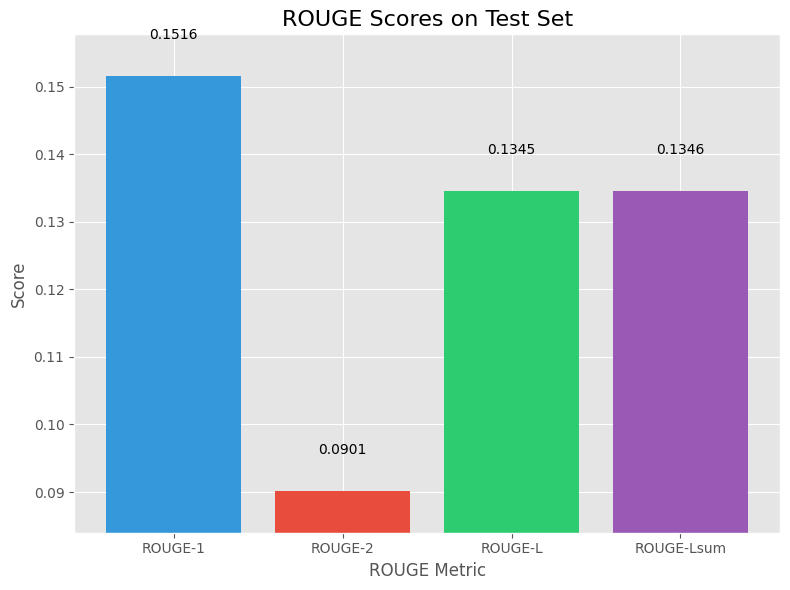

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert the relevant ROUGE scores to a pandas DataFrame
rouge_df = pd.DataFrame({
    'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-Lsum'],
    'Score': [
        rouge_results['rouge1'],
        rouge_results['rouge2'],
        rouge_results['rougeL'],
        rouge_results['rougeLsum']
    ]
})

# Create the bar chart
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(rouge_df['Metric'], rouge_df['Score'], color=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'])

# Add labels and title
ax.set_title('ROUGE Scores on Test Set', fontsize=16)
ax.set_xlabel('ROUGE Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)

# Adjust the y-axis limits to a smaller range to make the bars look bigger
min_score = rouge_df['Score'].min()
max_score = rouge_df['Score'].max()
padding = (max_score - min_score) * 0.1
ax.set_ylim(min_score - padding, max_score + padding)

# Add text labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 4), ha='center', va='bottom', fontsize=10)

# Save the plot
plt.tight_layout()
plt.savefig('rouge_scores_bar_chart_with_lsum.png')